## Forward Flight Performance

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [12]:
class Forward():
    """Clase que permite calcular los distintos tipos de potencia de un helicoptero
       en vuelo hacia adelante (vuelo nivelado), además calcula la potencia total
       Inputs:
           Voo (vector float): Las velocidades de vuelo hacia adelante
           hdens (float): La altitud densidad a la que deseamos hacer el cálculo
    """
    
    def __init__(self, Voo, hdens, H_Data):
        self.H_Data = H_Data
        self.f      = H_Data['f']       # [m^2]
        self.W      = H_Data['W']       # [N]
        self.R      = H_Data['R']       # [m]
        self.k      = H_Data['k']
        self.cuerda = H_Data['cuerda']  # [m]
        self.Cdo    = H_Data['Cdo']
        self.Nb     = H_Data['Nb']
        self.Omega  = H_Data['Omega']
        self.K      = H_Data['K']
        
        self.A      = np.pi*self.R**2        # [m^2]
        
        self.Voo    = Voo
        self.hdens  = hdens
        self.alpha  = [0 for V in Voo]
        self.thrust = [0 for V in Voo]
        self.vi     = [0 for V in Voo]
        self.kPi    = [0 for V in Voo]
        self.Po     = [0 for V in Voo]
        self.Pp     = [0 for V in Voo]
        self.Ptr    = [0 for V in Voo]
        self.Ptotal = [0 for V in Voo]
        self.efic   = [0 for V in Voo]
        self.dens   = 1.225*(1-self.hdens*(0.00357/518.4))**(1/0.235)
        self.dens_ratio = self.dens/1.225
        self.DF = pd.DataFrame({'Voo': self.Voo, 'alpha': self.alpha, 'T': self.thrust, 'Vi': self.vi, 'P Total': self.Ptotal, 'kPi': self.kPi, 'Po': self.Po, 'Pp': self.Pp, 'Ptr':self.Ptr})
        self.P_d_ssl = 300
        self.Wf     = 610   # lb
        self.SFC    = 0.77  # lb/hr*hp   
        self.rango  = [0 for V in Voo]
        self.tiempo = [0 for V in Voo]
        self.list_Vc = [0 for V in Voo]

        
    def alpha_func(self):
        """Método para calcular el ángulo de ataque para cada Voo, los almacena en self.alpha
        """
        i = 0
        for vel in self.Voo:
            alpha = np.arctan(0.5*self.dens*self.f*vel**2/(self.W))
            self.alpha[i] = round(alpha*360/(2*np.pi),3)
            i += 1
            
    def thrust_func(self):
        """Método para calcular el empuje para cada Voo, loa almacena en self.thrust
        """
        i = 0
        for attack in self.alpha:
            t = self.W/(np.cos(attack*2*np.pi/360)) #modificar W*cos
            self.thrust[i] = round(t,3)
            i += 1
    
    def vi_func(self):
        """Método para obtener Vi para cada Voo, la almacena en self.vi
           Primero calcula cada parte del polinomio de Vi para cada Voo y calcula las
           raíces para el mismo
        """
        a = []
        b = []
        c = []
        
        i = 0
        for v in self.Voo:
            a_i = 2*v*np.sin(self.alpha[i]*np.pi/180)
            a.append(a_i)
            b.append(v**2)
            t_i = self.thrust[i]**2/(4*(self.dens**2)*(self.A**2))
            c.append(t_i)
            i += 1
            
        i = 0
        for v in range(0,len(self.Voo)):
            p = np.poly1d([1,a[i],b[i],0,-c[i]])
            roots = p.r
            self.vi[i] = round(roots[3].real,3)
            i += 1
            
    def kPi_func(self):
        """Método que calcula Pi para cada Voo, la almacena en self.kPi
        """
        i = 0
        for t in self.thrust:
            k_i = self.k*t*(self.vi[i]+self.Voo[i]*np.sin(self.alpha[i]*np.pi/180))/745.7
            self.kPi[i] = round(k_i, 3)
            i += 1
    
    def Po_func(self):
        """Método para calcular Po para cada Voo, la almacena en self.Po
        """
        i = 0
        for v in self.Voo:
            Po_i = (1/745.7)*(1/8)*self.dens*self.cuerda*self.Cdo*self.Nb*(self.Omega**3)*(self.R**4)*(1+(self.K*(v**2)/((self.Omega**2)*(self.R**2))))
            self.Po[i] = round(Po_i,3)
            i += 1
                                                               
    def Pp_func(self):
        """Método para calcular Pp para cada Voo, la almacena en self.Pp
        """
        i = 0
        for v in self.Voo:
            Pp_i = 0.5*self.dens*(v**3)*self.f/745.7
            self.Pp[i] = round(Pp_i,3)
            i += 1
       
    def Ptr_func(self):
        """Método para calcular Ptr para cada Voo, la almacena en self.Ptr
        """
        i = 0
        for kPi in self.kPi:
            Ptr_i = (kPi + self.Po[i])*0.05
            self.Ptr[i] = round(Ptr_i,3)
            i += 1
            
    def Ptotal_func(self):
        """Método para calcular Ptotal para cada Voo, la almacena en self.Ptotal
        """
        i = 0
        for v in self.Voo:
            Ptotal_i = self.kPi[i] + self.Po[i] + self.Pp[i] + self.Ptr[i]
            self.Ptotal[i] = round(Ptotal_i, 3)
            i += 1
            
    def calc_Vc(self):
        """Método que calcula la Vc para cada Voo, a un hdens dada
        """
        i = 0
        for v in self.Voo:
            Vc_i = (self.dens_ratio*self.P_d_ssl*(745.7) - self.Ptotal[i]*745.7)/self.thrust[i]
            self.list_Vc[i] = Vc_i
            i += 1
            
    def calc_P(self):
        """Método que inicializa todos los valores de potencia y los calcula
        """
        self.__init__(self.Voo, self.hdens, self.H_Data)
        
        self.alpha_func()
        self.thrust_func()
        self.vi_func()
        self.kPi_func()
        self.Po_func()
        self.Pp_func()
        self.Ptr_func()
        self.Ptotal_func()
        self.calc_Vc()
        
    def calc_techo(self, alt_inicial):
        """Método que varía la altitud densidad hasta encontrar el techo de servicio
           Inputs:
               alt_inicial (float): Altitud para comenzar a iterar 
           Outputs:
               Techo de servicio
        """
        Error = 10
        alt_dens = alt_inicial
        self.hdens = alt_dens
        
        while Error > 0.01:
            self.hdens = alt_dens
            self.calc_P()
            P_min = min(self.Ptotal)
            P_disp = self.dens_ratio*self.P_d_ssl
            Error = abs(P_disp - P_min)
            alt_dens += 0.1
        
        return f'Techo de servicio: {alt_dens} ft'
          
    def calc_techo_hover(self, alt_inicial):
        """Método que varía la altitud densidad hasta encontrar el techo de servicio en hover
           Inputs:
               alt_inicial (float): Altitud para comenzar a iterar 
           Outputs:
               Techo de servicio en hover
        """
        Error = 10
        alt_dens = alt_inicial
        self.hdens = alt_dens
        
        while Error > 0.01:
            self.hdens = alt_dens
            self.calc_P()
            P_h = self.Ptotal[0]
            P_disp = self.dens_ratio*self.P_d_ssl
            Error = abs(P_disp - P_h)
            alt_dens += 0.1
        
        return f'Techo de servicio en Hover: {alt_dens} ft'
        
    def efic_func(self):
        """Método para calcular L/D para cada Voo, la almacena en self.efic
        """
        self.calc_P()
        
        i = 0
        for V in self.Voo:
            efic_i = (self.W*self.Voo[i])/(self.kPi[i] +self.Po[i] +self.Pp[i])
            self.efic[i] = round(efic_i,3)
            i += 1
            
    def tiempo_func(self):
        """Método para calcular el tiempo de vuelo con una cantidad dada de combustible
           en vuelo nivelado, para distintas velocidades.
        """
        self.calc_P()
        
        i = 0
        for v in self.Voo:
            t_i = self.Wf/(self.SFC*self.Ptotal[i])
            self.tiempo[i] = (round(t_i,3))
            i += 1
            
    def rango_func(self):
        """Método para calcular el rango de vuelo con una cantidad de combustible,
           en vuelo nivelado, para distintas velocidades
        """
        self.calc_P()
        
        i = 0
        for v in self.Voo:
            r_i = v*self.Wf*3.600/(self.SFC*self.Ptotal[i])
            self.rango[i] = (round(r_i,3))
            i += 1
            
    def graf_P(self):
        """Método que calcula y grafica todos los tipos de potencia en una sóla figura
        """
        self.calc_P()
        
        plt.plot(self.Voo, self.Ptotal, label='P Total')
        plt.plot(self.Voo, self.kPi, label = 'Kpi')
        plt.plot(self.Voo, self.Po, label='Po')
        plt.plot(self.Voo, self.Pp, label='Pp')
        plt.plot(self.Voo, self.Ptr, label='Ptr')

        plt.xlabel('Velocidad de avance [m/s]')
        plt.ylabel('Potencia [hp]')
        plt.title('Potencia vs Voo')

        plt.legend()
        leg = plt.legend(loc = 2, ncol = 2, prop = {'size': 11})
        
    def graf_P_total(self):
        """Método que calcula y grafica todos los tipos de potencia en una sóla figura
        """
        self.calc_P()
        
        plt.plot(self.Voo, self.Ptotal, label = f"hdens = {self.hdens}'")

        plt.xlabel('Velocidad de avance [m/s]')
        plt.ylabel('Potencia [hp]')
        plt.title('Potencia Total vs Voo')

        plt.legend()
        #leg = plt.legend(loc = 2, ncol = 2, prop = {'size': 11})
        
    def graf_efic(self):
        """Método que calcula y grafica gráfica la eficiencia a distintas Voo
        """
        self.efic_func()
        
        plt.plot(self.Voo, self.efic, label = f"hd = {self.hdens}''")
        
        plt.xlabel('Velocidad de avance [m/s]')
        plt.ylabel('L/D')
        plt.title('Eficiencia vs Voo')
        
        plt.legend()
        leg = plt.legend(loc = 4, ncol = 2, prop = {'size':11})
        
    def graf_r_t(self):
        """Método que calcula y grafica rango y endurance para un peso de combustible
           en vuelo nivelado, para distintas velocidades
        """
        self.rango_func()
        rango = self.rango
        self.tiempo_func()
        self.rango = rango
        
        plt.figure(num=2, figsize=[10,15], dpi=100)
        fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True)

        ax1.plot(self.Voo, self.rango, label = f'hdens = {self.hdens}')

        ax2.plot(self.Voo, self.tiempo, label = f'hdens = {self.hdens}')


        #ax1.set_xlabel('Velocidad de avance [m/s]')
        ax1.set_ylabel('Rango [km]')
        ax1.set_title('Performance Bell 206')


        ax2.set_xlabel('Velocidad de avance [m/s]')
        ax2.set_ylabel('Tiempo [hr]')
        ax2.set_title('Endurance')

        plt.show()
        
    def data_frame(self):
        """Método que muestra un Data Frame de potencias
           Inputs:
               None
           Outputs:
               self.PD (Data Frame)
        """
        self.calc_P()
        
        self.DF = pd.DataFrame({'Voo': self.Voo, 'alpha': self.alpha, 'T': self.thrust, 'Vi': self.vi, 'P Total': self.Ptotal, 'Vc [m/s]': self.list_Vc, 'kPi': self.kPi, 'Po': self.Po, 'Pp': self.Pp, 'Ptr': self.Ptr})
        
        return self.DF

### Gráfica de todas las potencias a una hdens

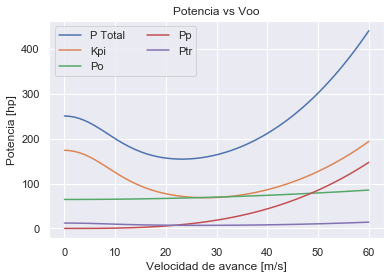

In [13]:
Heli_Ab = {'f': 0.83, 
           'W': 9.81*1451-610,
           'R': 5.08,
           'k': 1.15,
           'cuerda': 0.33,
           'Cdo': 0.01,
           'Nb': 2,
           'Omega': 41.5,
           'K': 4}

Voo = [V for V in range(0,61,1)]

HELI_1 = Forward(Voo, 0, Heli_Ab)

HELI_1.graf_P()

### Eficiencia a distintas altitud densidad

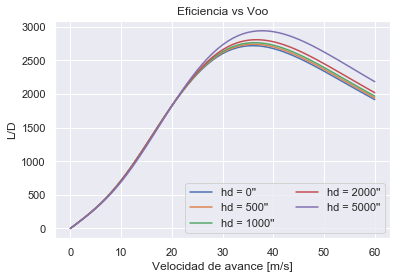

In [14]:
ef_0 = Forward(Voo,0, Heli_Ab)
ef_500 = Forward(Voo,500, Heli_Ab)
ef_1000 = Forward(Voo,1000, Heli_Ab)
ef_2000 = Forward(Voo,2000, Heli_Ab)
ef_5000 = Forward(Voo,5000, Heli_Ab)

ef_0.graf_efic()
ef_500.graf_efic()
ef_1000.graf_efic()
ef_2000.graf_efic()
ef_5000.graf_efic()

#plt.savefig('Eficiencia vs Voo a hdens.pdf')

## Gráfica Ptotal a diferentes altitud densidad

Creamos los objetos

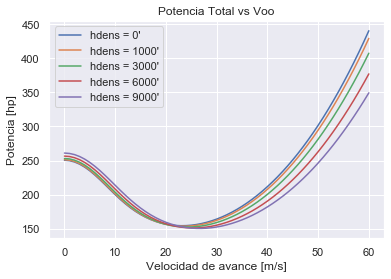

In [16]:
hp_0 = Forward(Voo,0, Heli_Ab)
hp_1000 = Forward(Voo, 1000, Heli_Ab)
hp_3000 = Forward(Voo, 3000, Heli_Ab)
hp_6000 = Forward(Voo, 6000, Heli_Ab)
hp_9000 = Forward(Voo, 9000, Heli_Ab)

hp_0.graf_P_total()
hp_1000.graf_P_total()
hp_3000.graf_P_total()
hp_6000.graf_P_total()
hp_9000.graf_P_total()

## Endurance y Rango

#### Calculamos y graficamos Rango y Endurance con los métodos del objeto de la clase Vel_avance

<Figure size 1000x1500 with 0 Axes>

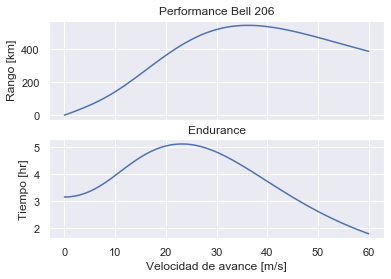

In [17]:
Heli_R_0 = Forward(Voo, 0, Heli_Ab)
Heli_R_0.graf_r_t()

In [18]:
max(Heli_R_0.rango)

546.635

## Techo de servicio vuelo hacia adelante

In [21]:
techo_f = Forward(Voo, 20988.7, Heli_Ab)

techo_f.calc_techo(20900)

'Techo de servicio: 20988.799999998708 ft'

#### Revisión

In [22]:
techo_f.dens_ratio*300

154.3863354338035

In [23]:
min(techo_f.Ptotal)

154.395

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(techo_f.DF)

    Voo  alpha  T  Vi  P Total  kPi  Po  Pp  Ptr
0     0      0  0   0        0    0   0   0    0
1     1      0  0   0        0    0   0   0    0
2     2      0  0   0        0    0   0   0    0
3     3      0  0   0        0    0   0   0    0
4     4      0  0   0        0    0   0   0    0
5     5      0  0   0        0    0   0   0    0
6     6      0  0   0        0    0   0   0    0
7     7      0  0   0        0    0   0   0    0
8     8      0  0   0        0    0   0   0    0
9     9      0  0   0        0    0   0   0    0
10   10      0  0   0        0    0   0   0    0
11   11      0  0   0        0    0   0   0    0
12   12      0  0   0        0    0   0   0    0
13   13      0  0   0        0    0   0   0    0
14   14      0  0   0        0    0   0   0    0
15   15      0  0   0        0    0   0   0    0
16   16      0  0   0        0    0   0   0    0
17   17      0  0   0        0    0   0   0    0
18   18      0  0   0        0    0   0   0    0
19   19      0  0   

### Techo de servicio en Hover

In [27]:
techo_h = Forward(Voo, 5356.5, Heli_Ab)

techo_h.calc_techo_hover(5000)

'Techo de servicio en Hover: 5356.500000001297 ft'

###### Revisión

In [28]:
techo_h.calc_P()
techo_h.Ptotal[0]

255.66

In [29]:
techo_h.dens_ratio * 300

255.65968637064736

## Exportar datos a excel

In [ ]:
data = pd.DataFrame({'Voo':Vav.Voo,'alpha':Vav.alpha,'T':Vav.thrust,'Vi':Vav.vi,'P Total':Vav.Ptotal,'kPi':Vav.kPi,'Po':Vav.Po,'Pp':Vav.Pp,'Ptr':Vav.Ptr})

In [ ]:
excel_w = pd.ExcelWriter('Potencias.xlsx', engine='xlsxwriter') #aquí se especifica el excel writer

data.to_excel(excel_w, sheet_name='Sheet1')                       #debemos suministrar el excel writer y nombre de la hoja

excel_w.save()